# Initial setup
- Library imports
- Utility functions
- Formatting JSON input

In [1]:
import pandas as pd
import numpy as np
import json
import os
import wget
import cv2
import matplotlib.pyplot as plt

from PIL import Image
import requests
from io import BytesIO

In [2]:
with open(f"items/items.json", "r") as fp:
    item_dict = json.load(fp)
    ITEMS = {i: item_dict[i]["name"] for i in item_dict.keys()}
    ITEM_ICONS = {i: item_dict[i]["icon"] for i in item_dict.keys()}

with open(f"champions.json", "r", encoding="utf-8") as fp:
    CHAMP_DICT = json.load(fp)
    CHAMP_NAME_TO_ID = {c: CHAMP_DICT[c]["id"] for c in CHAMP_DICT.keys()}
    CHAMP_ID_TO_NAME = {CHAMP_DICT[c]["id"]: c for c in CHAMP_DICT.keys()}
    CHAMPION_ICONS = {c: CHAMP_DICT[c]["icon"] for c in CHAMP_DICT.keys()}

def get_item_name(item_id: int):
    return ITEMS.get(str(int(item_id)), "")

def get_item_icon(item_id: int):
    if not item_id:
        return None
    url = ITEM_ICONS.get(str(int(item_id)))
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        return img
    except:
        return Image.new("RGB", (64, 64))

def get_champion_id(champion_name: str):
    if champion_name is None:
        return None
    return CHAMP_NAME_TO_ID.get(champion_name, "")

def get_champion_name(champion_id: int):
    return CHAMP_ID_TO_NAME.get(champion_id)

def get_champion_icon(champion_name: int):
    if not champion_name:
        return None
    url = CHAMPION_ICONS.get(champion_name)
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        return img
    except:
        return Image.new("RGB", (64, 64))

In [3]:
feature_dir = os.path.join("features", "postgame")
filenames = os.listdir(feature_dir)

df_list = []
for fn in filenames:
    sub_df = pd.read_json(os.path.join(feature_dir, fn))
    df_list.append(sub_df)

df = pd.concat(df_list)

print(f"Found {len(df)} matches")

Found 22355 matches


In [4]:
df_expanded = pd.concat([
    df[col].apply(pd.Series).add_prefix(f'{col}_')
    for col in df.columns
], axis=1)

for i in range(10):
    items_col = f"{i}_items"
    items_expanded = df_expanded[items_col].apply(pd.Series)
    items_expanded.columns = [f"{items_col}_{j}" for j in range(items_expanded.shape[1])]
    df_expanded = pd.concat([df_expanded, items_expanded], axis=1)
    df_expanded.drop(f"{i}_items", axis=1, inplace=True)

In [5]:
LANES = ["TOP", "JUNGLE", "MIDDLE", "BOTTOM", "UTILITY"]
print(f"Total matches: {len(df_expanded)}")
df_same_lane = df_expanded[
    (df_expanded["0_lane"] == "TOP")     & (df_expanded["1_lane"] == "TOP") &
    (df_expanded["2_lane"] == "JUNGLE")  & (df_expanded["3_lane"] == "JUNGLE") &
    (df_expanded["4_lane"] == "MIDDLE")  & (df_expanded["5_lane"] == "MIDDLE") &
    (df_expanded["6_lane"] == "BOTTOM")  & (df_expanded["7_lane"] == "BOTTOM") & 
    (df_expanded["8_lane"] == "UTILITY") & (df_expanded["9_lane"] == "UTILITY")
]
print(f"Number of matches with correct lane setup: {len(df_same_lane)}")
df_same_lane.to_csv("features/features_expanded.csv", index=False)

Total matches: 22355
Number of matches with correct lane setup: 21650


In [6]:
# Load champion IDs
with open(f"champions.json", "r", encoding="utf-8") as f:
    json_data = json.load(f)
    info = {json_data[champion]["id"]: champion for champion in json_data.keys()}

# Load Item IDs (Only legendary items)
with open(f"items/items.json", "r", encoding="utf-8") as f:
    json_data = json.load(f)
    item_ids = [json_data[str_id]["id"] for str_id in json_data.keys() if json_data[str_id]["tier"] in [3, 4]]
    item_ids = set(item_ids)

In [7]:
OHE_PLAYER_COLS = [f"player_{c}" for c in CHAMP_NAME_TO_ID.keys()]
OHE_ALLY_COLS = [f"ally_{c}" for c in CHAMP_NAME_TO_ID.keys()]
OHE_ENEMY_COLS = [f"enemy_{c}" for c in CHAMP_NAME_TO_ID.keys()]

# Creating examples
Creating 10 examples out of each match.

In [8]:
# Takes some time to process
def get_team_champions_and_gold(row):
    info = {
        "champions": {
            team: []
            for team in [100, 200]
        },
        "gold": {
            team: 0
            for team in [100, 200]
        },
    }
    for id in range(10):
        info["champions"][row[f"{id}_teamId"]].append(get_champion_name(row[f"{id}_championId"]))
        info["gold"][row[f"{id}_teamId"]] += row[f"{id}_goldEarned"]
    return info["champions"], info["gold"]

def build_new_row(row, cols, playerId, allies, enemies, gold):
    new_row = {}
    player_champion = get_champion_name(row[f"{playerId}_championId"])

    # Player info
    for c in cols:
        new_row[c] = row[f"{playerId}_{c}"]

    # OHE for lane
    new_row[row[f"{playerId}_lane"]] = 1

    new_row[f"player_{player_champion}"] = 1

    # OHE for allies and enemies
    for champ in allies:
        if champ != player_champion:
            new_row[f"ally_{champ}"] = 1
    for champ in enemies:
        new_row[f"enemy_{champ}"] = 1

    new_row["teamGold"] = gold

    return new_row

def expand_match(row):
    team_champions, team_gold = get_team_champions_and_gold(row)
    cols = ["championId", "kills", "deaths", "assists", "goldEarned"] + [f"items_{i}" for i in range(6)]
    new_rows = []

    for playerId in range(10):
        team = row[f"{playerId}_teamId"]
        allies = team_champions[team]
        gold = team_gold[team]
        enemies = team_champions[100 if team == 200 else 200]

        row_data = build_new_row(row, cols, playerId, allies, enemies, gold)
        new_rows.append(row_data)

    return pd.DataFrame(new_rows)

expanded_list = df_same_lane.apply(expand_match, axis=1).tolist()
input_df = pd.concat(expanded_list, ignore_index=True, axis=0).fillna(0)

In [9]:
new_cols = pd.DataFrame({
    "KDA": (input_df["kills"] + input_df["assists"]) / input_df["deaths"],
    "relativeGold": input_df["goldEarned"] / input_df["teamGold"]
})

input_df = pd.concat([input_df, new_cols], axis=1)

## Filtering for high-performance matches

In [10]:
# Amount of games with good performance
for lane in LANES:
    total_matches = len(input_df[(input_df[lane] == 1)])
    print(f"Lane: {lane} -- total matches: {total_matches}")
    lane_df = pd.DataFrame(dtype=str)
    for kda in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]:
        for relativeGold in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]:
            ratio = len(
                input_df[(input_df[lane] == 1) & \
                         (input_df["KDA"] >= kda) & \
                         (input_df["relativeGold"] >= relativeGold)
                        ]
            ) / total_matches
            lane_df.loc[f"KDA>={kda}", f"gold>={relativeGold}"] = f"{ratio*100:.2f}%"
    display(lane_df)

Lane: TOP -- total matches: 43300


gold>=0.05 gold>=0.1 gold>=0.15 gold>=0.2 gold>=0.25 gold>=0.3  \
KDA>=0.5     89.73%    89.72%     88.49%    51.94%      7.66%     0.32%   
KDA>=1.0     75.42%    75.41%     74.63%    46.06%      7.38%     0.32%   
KDA>=1.5     58.48%    58.47%     58.03%    37.63%      6.54%     0.30%   
KDA>=2.0     46.90%    46.90%     46.58%    31.38%      5.73%     0.28%   
KDA>=2.5     36.08%    36.08%     35.88%    24.85%      4.79%     0.24%   
KDA>=3.0     29.67%    29.67%     29.53%    20.88%      4.15%     0.22%   

         gold>=0.35  
KDA>=0.5      0.00%  
KDA>=1.0      0.00%  
KDA>=1.5      0.00%  
KDA>=2.0      0.00%  
KDA>=2.5      0.00%  
KDA>=3.0      0.00%

Lane: JUNGLE -- total matches: 43300


gold>=0.05 gold>=0.1 gold>=0.15 gold>=0.2 gold>=0.25 gold>=0.3  \
KDA>=0.5     95.85%    95.85%     95.58%    64.88%      9.77%     0.37%   
KDA>=1.0     88.38%    88.38%     88.19%    61.40%      9.58%     0.37%   
KDA>=1.5     75.33%    75.33%     75.22%    53.92%      9.00%     0.36%   
KDA>=2.0     63.73%    63.73%     63.65%    46.68%      8.14%     0.34%   
KDA>=2.5     52.66%    52.66%     52.60%    39.33%      7.24%     0.31%   
KDA>=3.0     45.16%    45.16%     45.12%    34.33%      6.44%     0.28%   

         gold>=0.35  
KDA>=0.5      0.01%  
KDA>=1.0      0.01%  
KDA>=1.5      0.01%  
KDA>=2.0      0.01%  
KDA>=2.5      0.01%  
KDA>=3.0      0.01%

Lane: MIDDLE -- total matches: 43300


gold>=0.05 gold>=0.1 gold>=0.15 gold>=0.2 gold>=0.25 gold>=0.3  \
KDA>=0.5     93.58%    93.58%     92.99%    59.55%      8.87%     0.42%   
KDA>=1.0     83.65%    83.64%     83.19%    55.08%      8.64%     0.42%   
KDA>=1.5     68.86%    68.85%     68.59%    46.90%      7.86%     0.40%   
KDA>=2.0     57.48%    57.48%     57.28%    40.25%      6.96%     0.38%   
KDA>=2.5     45.82%    45.82%     45.70%    32.97%      5.93%     0.35%   
KDA>=3.0     38.33%    38.33%     38.23%    28.09%      5.20%     0.30%   

         gold>=0.35  
KDA>=0.5      0.01%  
KDA>=1.0      0.01%  
KDA>=1.5      0.01%  
KDA>=2.0      0.01%  
KDA>=2.5      0.01%  
KDA>=3.0      0.01%

Lane: BOTTOM -- total matches: 43300


gold>=0.05 gold>=0.1 gold>=0.15 gold>=0.2 gold>=0.25 gold>=0.3  \
KDA>=0.5     94.44%    94.44%     94.12%    71.31%     15.04%     0.91%   
KDA>=1.0     84.90%    84.90%     84.72%    66.37%     14.79%     0.91%   
KDA>=1.5     70.44%    70.44%     70.35%    57.06%     13.83%     0.89%   
KDA>=2.0     59.01%    59.01%     58.95%    48.89%     12.50%     0.85%   
KDA>=2.5     47.18%    47.18%     47.15%    40.12%     10.93%     0.79%   
KDA>=3.0     39.27%    39.27%     39.24%    33.85%      9.66%     0.73%   

         gold>=0.35  
KDA>=0.5      0.03%  
KDA>=1.0      0.03%  
KDA>=1.5      0.03%  
KDA>=2.0      0.03%  
KDA>=2.5      0.03%  
KDA>=3.0      0.03%

Lane: UTILITY -- total matches: 43300


gold>=0.05 gold>=0.1 gold>=0.15 gold>=0.2 gold>=0.25 gold>=0.3  \
KDA>=0.5     96.11%    96.11%     42.51%     2.00%      0.06%     0.00%   
KDA>=1.0     89.17%    89.16%     39.69%     1.89%      0.06%     0.00%   
KDA>=1.5     76.59%    76.59%     34.21%     1.63%      0.05%     0.00%   
KDA>=2.0     65.39%    65.39%     29.40%     1.36%      0.04%     0.00%   
KDA>=2.5     54.00%    54.00%     24.55%     1.09%      0.04%     0.00%   
KDA>=3.0     46.18%    46.18%     21.33%     0.90%      0.04%     0.00%   

         gold>=0.35  
KDA>=0.5      0.00%  
KDA>=1.0      0.00%  
KDA>=1.5      0.00%  
KDA>=2.0      0.00%  
KDA>=2.5      0.00%  
KDA>=3.0      0.00%

In [11]:
# keep the top ~70% of the matches
HIGH_PERFORMANCE_INDICATORS = {
    "TOP": {
        "KDA": 1.0,
        "relativeGold": 0.15
    },
    "JUNGLE": {
        "KDA": 1.5,
        "relativeGold": 0.15
    },
    "MIDDLE": {
        "KDA": 1.0,
        "relativeGold": 0.15
    },
    "BOTTOM": {
        "KDA": 1.5,
        "relativeGold": 0.15
    },
    "UTILITY": {
        "KDA": 1.5,
        "relativeGold": 0.1
    },
}

def keep_high_performance(row):
    lane = "".join([lane for lane in LANES if row[lane] == 1])
    for indicator, min_val in HIGH_PERFORMANCE_INDICATORS[lane].items():
        if row[indicator] < min_val:
            return False
    return True

high_df = input_df[input_df.apply(keep_high_performance, axis=1)]
print(f"Final number of examples: {len(high_df)}")

Final number of examples: 168022


In [12]:
high_df.head()

championId  kills  deaths  assists  goldEarned  items_0  items_1  items_2  \
1          84     17       4        4       12871   3020.0   4645.0   4646.0   
3         950      2       4       15       10327   6692.0   6698.0   3158.0   
4         112      2       8        6        7440   3040.0   3100.0      0.0   
5          55     13       2        5       11525   3020.0   3100.0   4645.0   
6         202      4       6        5        8019   3094.0   6676.0   3009.0   

   items_3  items_4  ...  enemy_Neeko  player_Neeko  ally_Nilah  enemy_Nilah  \
1      0.0      0.0  ...          0.0           0.0         0.0          0.0   
3      0.0      0.0  ...          0.0           0.0         0.0          0.0   
4      0.0      0.0  ...          0.0           0.0         0.0          0.0   
5      0.0      0.0  ...          0.0           0.0         0.0          0.0   
6      0.0      0.0  ...          0.0           0.0         0.0          0.0   

   player_Nilah  enemy_Shyvana  ally_Shyvana  player_Shyvana   KDA  \
1           0.0            0.0           0.0             0.0  5.25   
3           0.0            0.0           0.0             0.0  4.25   
4           0.0            0.0           0.0             0.0  1.00   
5           0.0            0.0           0.0             0.0  9.00   
6           0.0            0.0           0.0             0.0  1.50   

   relativeGold  
1      0.258974  
3      0.207787  
4      0.192731  
5      0.231891  
6      0.207730  

[5 rows x 529 columns]

## Defining input and output vectors

In [13]:
input_cols = [
    col for col in high_df.columns
    if any(
           [col.startswith(prefix) for prefix in ["player", "ally", "enemy"]]
          ) or col in LANES

]
output_cols = [
    col for col in high_df.columns
    if col.startswith("items")
]

championIds = high_df["championId"]
X = high_df[input_cols]
y = high_df[output_cols]

print(f"Total examples: {len(X)}")

Total examples: 168022


# Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, make_scorer, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, KFold

from scipy.stats import randint, uniform  # for distributions

In [15]:
# `y_class` is shape (n_samples, 6) with 0s as padding

# Convert to sets of items (removing zeros)
y_sets = y.apply(lambda row: [int(i) for i in row if i != 0 and not pd.isna(i)], axis=1)

# Binarize
mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(y_sets)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.5, random_state=42, stratify=championIds
)

In [16]:
from sklearn.metrics import make_scorer, f1_score
import numpy as np

def make_top_k_f1_scorer(mlb, k=6):
    def top_k_f1_score(estimator, X, y_true):
        try:
            y_proba = estimator.predict_proba(X)

            # Ensure we have probabilities for all classes in mlb.classes_
            if len(y_proba) != len(mlb.classes_):
                # Create full matrix with zeros, then fill in existing probabilities
                proba_matrix = np.zeros((X.shape[0], len(mlb.classes_)))
                trained_classes = estimator.classes_
                for i, cls in enumerate(trained_classes):
                    class_index = np.where(mlb.classes_ == cls)[0][0]
                    proba_matrix[:, class_index] = y_proba[i][:, 1]
            else:
                proba_matrix = np.array([p[:, 1] for p in y_proba]).T

            top_k_preds = np.argsort(proba_matrix, axis=1)[:, -k:][:, ::-1]
            pred_sets = [[mlb.classes_[idx] for idx in row] for row in top_k_preds]
            pred_bin = mlb.transform(pred_sets)

            return f1_score(y_true, pred_bin, average='samples', zero_division=0)

        except Exception as e:
            # Return a very low score if something fails, to avoid crashing search
            return 0.0

    return make_scorer(top_k_f1_score, needs_proba=False)

In [17]:
base_rf = RandomForestClassifier(random_state=42, n_jobs=1)
multi_rf = MultiOutputClassifier(base_rf, n_jobs=1)

In [18]:
param_dist = {
    'estimator__n_estimators': randint(10, 30),
    'estimator__max_depth': randint(5, 15),
    'estimator__min_samples_leaf': randint(5, 20),
    'estimator__ccp_alpha': uniform(0.0, 0.01)
}

kf = KFold(n_splits=3, shuffle=True, random_state=42)
custom_scorer = make_top_k_f1_scorer(mlb, k=6)

random_search = RandomizedSearchCV(
    estimator=multi_rf,
    param_distributions=param_dist,
    n_iter=10,  # number of sampled combinations
    scoring=custom_scorer,
    cv=kf,
    verbose=3,
    n_jobs=4,
    refit=True,
    random_state=42
)

In [19]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
best_model = random_search.best_estimator_

# Optional: Evaluate on your separate test set if you have one
y_proba = best_model.predict_proba(X_test)
proba_matrix = np.array([p[:, 1] for p in y_proba]).T
top_6_preds = np.argsort(proba_matrix, axis=1)[:, -6:][:, ::-1]
pred_sets = [[mlb.classes_[idx] for idx in row] for row in top_6_preds]
pred_bin = mlb.transform(pred_sets)

# pred_bin: binary matrix (n_samples, n_labels), 1s in top-6 slots
# y_test: binary matrix of ground truth

recall_at_6 = recall_score(y_test, pred_bin, average='samples', zero_division=0)
precision_at_6 = precision_score(y_test, pred_bin, average='samples', zero_division=0)

print(f"Recall@6: {recall_at_6:.4f}")
print(f"Precision@6: {precision_at_6:.4f}")

Recall@6: 0.3658
Precision@6: 0.2112


# MLP

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

In [21]:
from sklearn.model_selection import train_test_split
import torch
import numpy as np

# Split X and y while keeping y as DataFrame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=championIds)

# Multi-hot encode y
unique_item_ids = sorted(set(np.unique(y.values.flatten())) - {0})  # Removing zero (assumed as 'no item' marker)
item_id_to_idx = {item_id: idx for idx, item_id in enumerate(unique_item_ids)}
num_items = len(unique_item_ids)
print(f"Total items: {num_items}")

def multi_hot_encode(row):
    vec = np.zeros(num_items, dtype=np.float32)
    for item_id in row:
        if item_id != 0:
            vec[item_id_to_idx[item_id]] = 1.0
    return vec

# Convert y_train
y_train_multi_hot = np.vstack(y_train.apply(multi_hot_encode, axis=1).to_numpy())
y_train_tensor = torch.tensor(y_train_multi_hot, dtype=torch.float32)

# Convert y_test
y_test_multi_hot = np.vstack(y_test.apply(multi_hot_encode, axis=1).to_numpy())
y_test_tensor = torch.tensor(y_test_multi_hot, dtype=torch.float32)

# Convert X
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

Total items: 121


In [27]:
import torch
import torch.nn as nn

class ClassifierChainMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ClassifierChainMLP, self).__init__()
        self.output_dim = output_dim

        # Shared hidden layers
        self.hidden = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # One output layer per label, input = [features + previous predictions]
        self.output_layers = nn.ModuleList([
            nn.Linear(64 + i, 1) for i in range(output_dim)
        ])

    def forward(self, x, y=None):
        """
        x: (batch_size, input_dim)
        y: (batch_size, output_dim) — only passed during training for teacher forcing
        Returns:
            logits: (batch_size, output_dim)
        """
        use_teacher_forcing = self.training and y is not None
        batch_size = x.size(0)

        h = self.hidden(x)  # shape: (batch_size, 64)
        preds = []  # list of predicted label probabilities (detached if not using teacher forcing)
        logits = []  # list of raw logits (to compute loss)

        for i in range(self.output_dim):
            if i > 0:
                prev_inputs = torch.cat(preds, dim=1)  # shape: (batch_size, i)
                h_i = torch.cat([h, prev_inputs], dim=1)
            else:
                h_i = h

            logit_i = self.output_layers[i](h_i)  # shape: (batch_size, 1)
            logits.append(logit_i)

            # Choose next input to chain
            if use_teacher_forcing:
                # Use ground-truth label during training
                next_input = y[:, i].unsqueeze(1).float()
            else:
                # Use predicted probability during inference
                prob_i = torch.sigmoid(logit_i)  # shape: (batch_size, 1)
                next_input = prob_i.detach()     # avoid backprop through chain

            preds.append(next_input)

        return torch.cat(logits, dim=1)  # shape: (batch_size, output_dim)

In [ ]:
num_epochs = 5
batch_size = 128
k_folds = 5

criterion = nn.BCEWithLogitsLoss()
kfold = KFold(n_splits=k_folds, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_train_losses = []
all_val_losses = []

best_val_loss = float('inf')
best_model_state = None

early_stopping_patience = 3  # stop if no improvement after 3 epochs
early_stopping_counter = 0   # counts epochs with no improvement

for fold, (train_ids, val_ids) in enumerate(kfold.split(X_train_tensor)):
    print(f'\n=== Fold {fold+1}/{k_folds} ===')

    train_X, train_y = X_train_tensor[train_ids], y_train_tensor[train_ids]
    train_X, train_y = train_X.to(device), train_y.to(device)
    val_X, val_y = X_train_tensor[val_ids], y_train_tensor[val_ids]
    val_X, val_y = val_X.to(device), val_y.to(device)

    model = ClassifierChainMLP(input_dim=X.shape[1], output_dim=y_train_tensor.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    train_losses = []
    val_losses = []

    early_stopping_counter = 0
    best_fold_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        permutation = torch.randperm(train_X.size(0))
        total_loss = 0.0

        for i in range(0, train_X.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_X = train_X[indices]
            batch_y = train_y[indices]

            optimizer.zero_grad()
            outputs = model(batch_X, batch_y)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_X.size(0)

        avg_train_loss = total_loss / train_X.size(0)

        model.eval()
        with torch.no_grad():
            val_outputs = model(val_X)
            val_loss = criterion(val_outputs, val_y).item()

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1:02d}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}')

        # Early stopping check
        if val_loss < best_fold_val_loss:
            best_fold_val_loss = val_loss
            early_stopping_counter = 0
            # Save best model per fold
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)


=== Fold 1/5 ===
Epoch 01: Train Loss = 0.1201, Val Loss = 0.0869
Epoch 02: Train Loss = 0.0733, Val Loss = 0.0719
Epoch 03: Train Loss = 0.0641, Val Loss = 0.0675
Epoch 04: Train Loss = 0.0605, Val Loss = 0.0664
Epoch 05: Train Loss = 0.0583, Val Loss = 0.0654

=== Fold 2/5 ===
Epoch 01: Train Loss = 0.1186, Val Loss = 0.0844
Epoch 02: Train Loss = 0.0719, Val Loss = 0.0719
Epoch 03: Train Loss = 0.0643, Val Loss = 0.0680
Epoch 04: Train Loss = 0.0606, Val Loss = 0.0664
Epoch 05: Train Loss = 0.0584, Val Loss = 0.0657

=== Fold 3/5 ===
Epoch 01: Train Loss = 0.1214, Val Loss = 0.0864
Epoch 02: Train Loss = 0.0728, Val Loss = 0.0718
Epoch 03: Train Loss = 0.0644, Val Loss = 0.0680
Epoch 04: Train Loss = 0.0609, Val Loss = 0.0667
Epoch 05: Train Loss = 0.0587, Val Loss = 0.0656

=== Fold 4/5 ===
Epoch 01: Train Loss = 0.1193, Val Loss = 0.0852
Epoch 02: Train Loss = 0.0726, Val Loss = 0.0716
Epoch 03: Train Loss = 0.0642, Val Loss = 0.0678
Epoch 04: Train Loss = 0.0608, Val Loss = 0.06

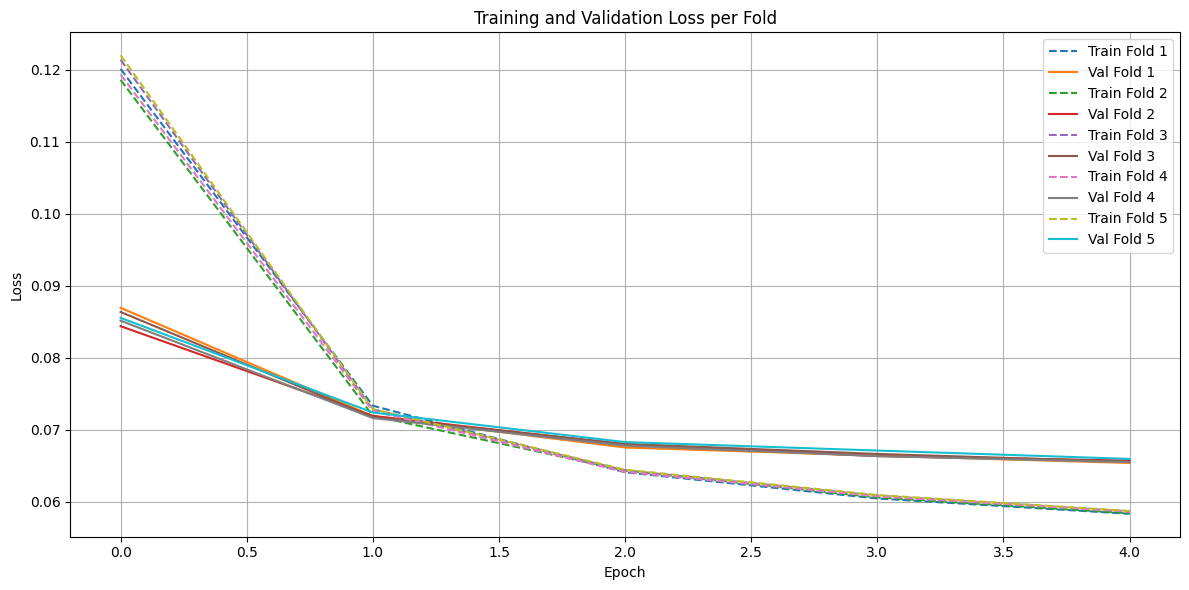

In [33]:
# Plotting after training
plt.figure(figsize=(12, 6))
for fold in range(k_folds):
    plt.plot(all_train_losses[fold], label=f'Train Fold {fold+1}', linestyle='--')
    plt.plot(all_val_losses[fold], label=f'Val Fold {fold+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Fold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Load best model
best_model = ClassifierChainMLP(input_dim=X.shape[1], output_dim=y_train_tensor.shape[1])
best_model.load_state_dict(best_model_state)

<All keys matched successfully>

In [ ]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)
    outputs = model(X_test_tensor)
    test_loss = criterion(outputs, y_test_tensor)
    print(f"Test Loss: {test_loss.item()}")

    # Get top 6 predictions for each sample
    _, top6_indices = torch.topk(outputs, k=6, dim=1)

    # Total number of samples
    total_samples = y_test_tensor.shape[0]
    all_slots_correct_samples = 0
    single_slot_correct_samples = 0

    for i in range(total_samples):
        # Indices of true labels (where y == 1)
        true_indices = (y_test_tensor[i] == 1).nonzero(as_tuple=True)[0]

        # Skip if there are no true labels (optional: depends on your definition of accuracy)
        if true_indices.numel() == 0:
            continue

        # Indices predicted as top-6
        predicted_top6 = top6_indices[i]

        single_slot_correct = 0
        # Check if all true labels are in the top-6
        if set(true_indices.tolist()).issubset(set(predicted_top6.tolist())):
            all_slots_correct_samples += 1
            single_slot_correct_samples += 1
        else:
            for idx in true_indices.tolist():
                if idx in set(predicted_top6.tolist()):
                    single_slot_correct += 1
            single_slot_correct_samples += single_slot_correct / len(true_indices.tolist())

    # Top-6 accuracy based only on rows that had at least one positive label
    all_slots_accuracy = all_slots_correct_samples / total_samples
    single_slot_accuracy = single_slot_correct_samples / total_samples
    print(f"All slots - accuracy: {all_slots_accuracy:.4f}")
    print(f"Single slot - accuracy: {single_slot_accuracy:.4f}")

Test Loss: 0.06588184088468552
All slots - accuracy: 0.3209
Single slot - accuracy: 0.6912


In [ ]:
import torch
from torchmetrics.classification import MultilabelRecall, MultilabelPrecision
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = y_test_tensor.shape[1]

recall_metric = MultilabelRecall(num_labels=num_labels, average='macro').to(device)
precision_metric = MultilabelPrecision(num_labels=num_labels, average='macro').to(device)

# Prepare X_custom tensor on device
# X_custom = pd.DataFrame(columns=X.columns)
# X_custom = pd.concat([pd.DataFrame([[0] * len(X_custom.columns)] * 256, columns=X_custom.columns), X_custom], ignore_index=True)
X_custom = X_test
X_custom_tensor = torch.tensor(X_custom.values.astype(np.float32)).to(device)

batch_size = 128
all_topk = []
all_preds = []
all_true = []

model.eval()
with torch.no_grad():
    for i in range(0, len(X_custom_tensor), batch_size):
        batch_X = X_custom_tensor[i:i+batch_size]
        outputs = model(batch_X)                    # raw logits
        probs = torch.sigmoid(outputs)              # probs needed for top-k
        topk_values, topk_indices = torch.topk(probs, k=6, dim=1)
        
        # Store topk indices for recommendations
        all_topk.append(topk_indices.cpu())
        
        # Build binary predictions for metrics
        preds_batch = torch.zeros_like(probs, dtype=torch.int)
        preds_batch.scatter_(1, topk_indices, 1)
        all_preds.append(preds_batch)
        
        # If you have true labels for X_custom, collect them similarly for metrics
        # Here assuming X_custom == X_test for evaluation:
        batch_y = y_test_tensor[i:i+batch_size].to(device)
        all_true.append(batch_y.int())

# Concatenate all batches
all_preds = torch.cat(all_preds, dim=0)
all_true = torch.cat(all_true, dim=0)

# Compute recall and precision at 6
recall_at_6 = recall_metric(all_preds.to(device), all_true.to(device))
precision_at_6 = precision_metric(all_preds.to(device), all_true.to(device))

print(f"Recall@6: {recall_at_6.item():.4f}")
print(f"Precision@6: {precision_at_6.item():.4f}")

# Flatten all_topk for mapping indices to item IDs
all_topk = torch.cat(all_topk, dim=0)

all_recommendations = []
for topk_indices in all_topk:
    predicted_items = [id for id, idx in item_id_to_idx.items() if idx in topk_indices]
    all_recommendations.append(predicted_items)


Recall@6: 0.5204
Precision@6: 0.3362


In [48]:
def show_build(item_ids):
    fig, axs = plt.subplots(1, len(item_ids), figsize=(2 * len(item_ids), 2))
    if len(item_ids) == 1:
        axs = [axs]  # ensure iterable
    for i, id in enumerate(item_ids):
        icon = get_item_icon(id)
        if icon:
            axs[i].imshow(icon)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

def compare_builds(
        df: pd.DataFrame,
        all_recommendations: list,
        build_df,
        original_index,
        idx: int):
    orig_idx = original_index[idx]

    allies = []
    enemies = []
    analysed_champion = ""
    for col in df.columns:
        if df.loc[orig_idx, col] == 0:
            continue
        if col.startswith("player"):
            analysed_champion = col.split("_")[1]
            print(f"Champion: {analysed_champion}")
        elif col.startswith("ally"):
            allies.append(col.split("_")[1])
        elif col.startswith("enemy"):
            enemies.append(col.split("_")[1])
        elif col in LANES:
            print(f"Lane: {col.lower().capitalize()}")

    reccomended_items = sorted(all_recommendations[idx], key=lambda x: x if x > 0 else 9999)
    print(f"Allies: {', '.join(champ for champ in allies)}")
    print(f"Enemies: {', '.join(champ for champ in enemies)}")
    print(f"Recommendations: {', '.join(
        [f"{get_item_name(item):<30}" for item in reccomended_items]
    )}")

    original_build = []
    for i in range(6):
        item_col = f"items_{i}"
        item_id = build_df.loc[orig_idx, item_col]
        if item_id.is_integer():
            original_build.append(int(item_id))
    original_build.sort(key=lambda x: x if x > 0 else 9999)
    print(f"Original IDX: {orig_idx}")
    print(f"Original build : {', '.join(
        [f'{get_item_name(item):<30}' for item in original_build]
    )}")

    print("Recommended build")
    show_build(sorted(reccomended_items))

    print("Original build")
    show_build(sorted(original_build, key=lambda x: x if x > 0 else 9999))

In [49]:
# selected_champion = X_custom["championId"].value_counts().idxmax()
selected_champion = "Kaisa"
selected_champion_id = get_champion_id(selected_champion)
print(f"Selected champion: {get_champion_name(selected_champion)} - ID: {selected_champion_id}")

Selected champion: None - ID: 145


In [50]:
df_selected = X_custom.iloc[:len(all_recommendations), :]
df_selected.loc[:, "index"] = range(len(df_selected))
df_selected = df_selected[df_selected[f"player_{selected_champion}"] == 1]

C:\Users\User\AppData\Local\Temp\ipykernel_19920\599549783.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.loc[:, "index"] = range(len(df_selected))


Lane: Bottom
Champion: Kaisa
Allies: Morgana, Sona, Lux, Darius
Enemies: Yone, TahmKench, Seraphine, MissFortune, Kayn
Recommendations: Berserker's Greaves           , Statikk Shiv                  , Nashor's Tooth                , Guinsoo's Rageblade           , Terminus                      , Kraken Slayer                 
Original IDX: 64736
Original build : Berserker's Greaves           , Muramana                      , Nashor's Tooth                , Shadowflame                   , Luden's Companion             ,                               
Recommended build


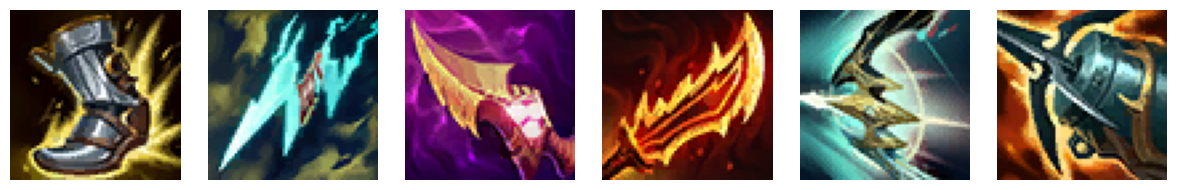

Original build


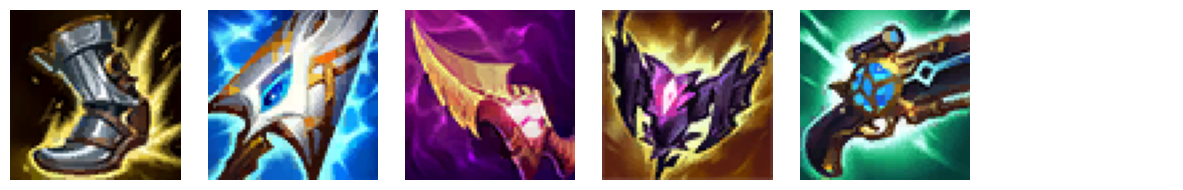

Lane: Bottom
Champion: Kaisa
Allies: Katarina, Jax, Sylas, Zed
Enemies: Akali, Yone, Nautilus, Ezreal, Sejuani
Recommendations: Berserker's Greaves           , Statikk Shiv                  , Nashor's Tooth                , Guinsoo's Rageblade           , Terminus                      , Kraken Slayer                 
Original IDX: 202666
Original build : Berserker's Greaves           , Kraken Slayer                 ,                               ,                               ,                               ,                               
Recommended build


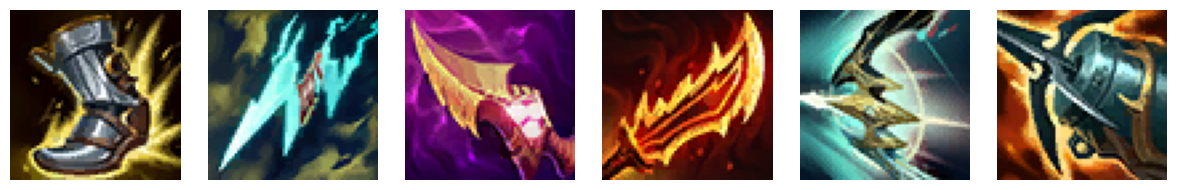

Original build


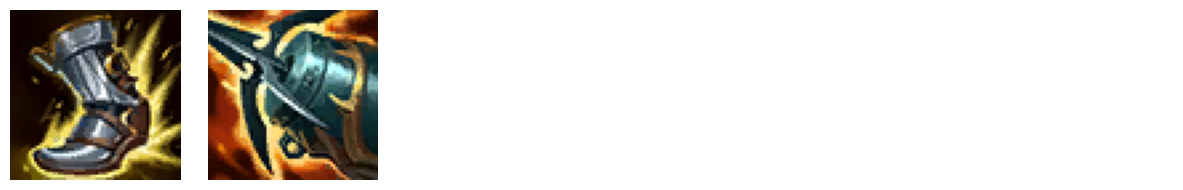

Lane: Bottom
Champion: Kaisa
Allies: Katarina, Nautilus, Trundle, Briar
Enemies: Nami, Mordekaiser, MissFortune, Lillia, Heimerdinger
Recommendations: Berserker's Greaves           , Statikk Shiv                  , Nashor's Tooth                , Guinsoo's Rageblade           , Terminus                      , Kraken Slayer                 
Original IDX: 178456
Original build : Sorcerer's Shoes              , Statikk Shiv                  , Guinsoo's Rageblade           ,                               ,                               ,                               
Recommended build


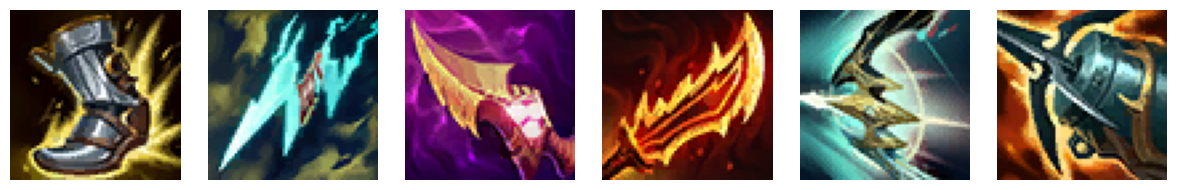

Original build


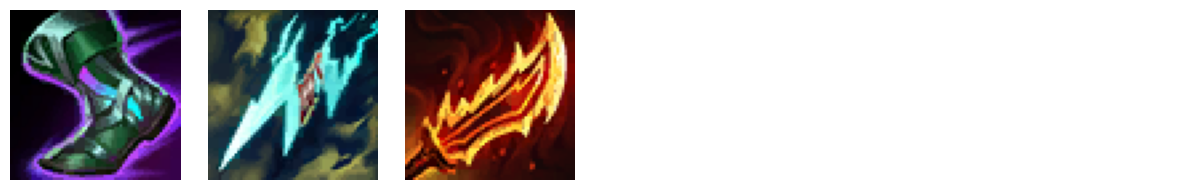

Lane: Bottom
Champion: Kaisa
Allies: Sylas, Alistar, Camille, Talon
Enemies: Jhin, Pyke, Ornn, Syndra, Nunu
Recommendations: Berserker's Greaves           , Yun Tal Wildarrows            , Statikk Shiv                  , Nashor's Tooth                , Guinsoo's Rageblade           , Kraken Slayer                 
Original IDX: 3097
Original build : Sorcerer's Shoes              , Muramana                      , Cryptbloom                    , Luden's Companion             ,                               ,                               
Recommended build


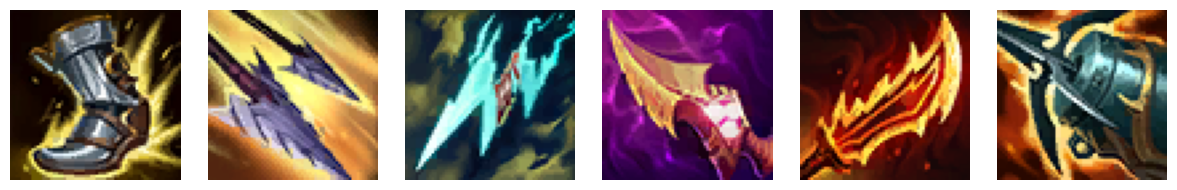

Original build


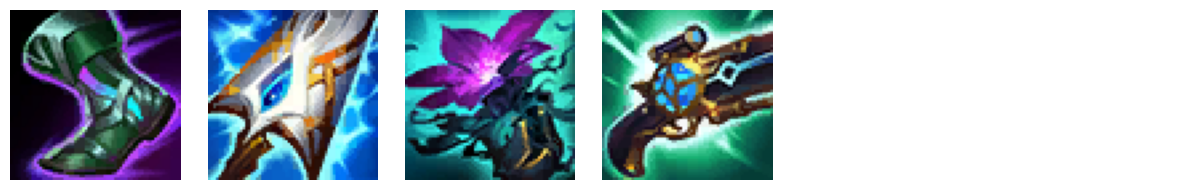

Lane: Bottom
Champion: Kaisa
Allies: Yasuo, MonkeyKing, Maokai, Singed
Enemies: Kayle, Jinx, Sona, AurelionSol, Kayn
Recommendations: Berserker's Greaves           , Statikk Shiv                  , Nashor's Tooth                , Guinsoo's Rageblade           , Terminus                      , Kraken Slayer                 
Original IDX: 22237
Original build : Statikk Shiv                  ,                               ,                               ,                               ,                               ,                               
Recommended build


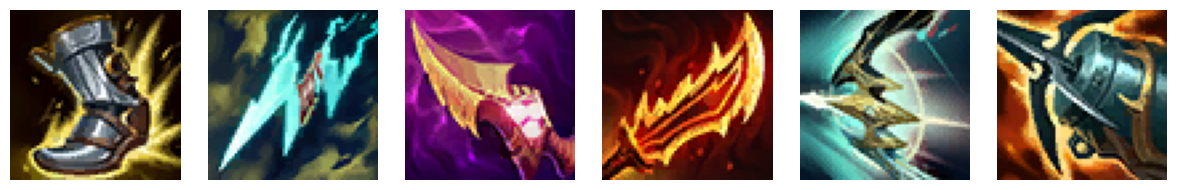

Original build


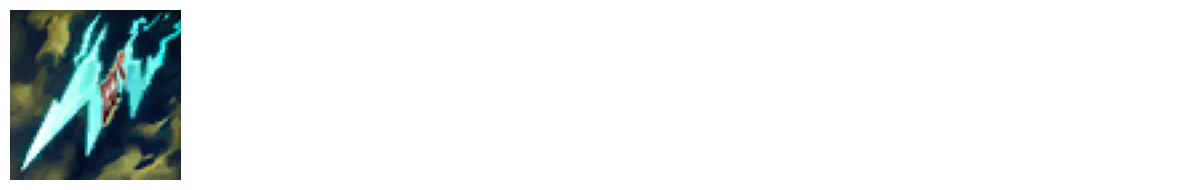

Lane: Bottom
Champion: Kaisa
Allies: Yone, Rell, Kassadin, Trundle
Enemies: Pantheon, Nasus, Singed, Milio, KogMaw
Recommendations: Berserker's Greaves           , Statikk Shiv                  , Nashor's Tooth                , Guinsoo's Rageblade           , Terminus                      , Kraken Slayer                 
Original IDX: 209536
Original build : Guinsoo's Rageblade           , Blade of the Ruined King      , Zephyr                        , Terminus                      , Kraken Slayer                 ,                               
Recommended build


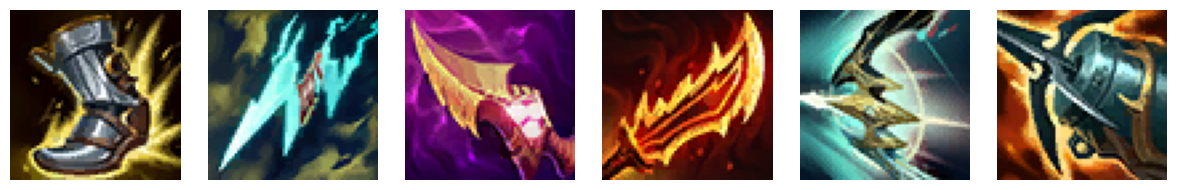

Original build


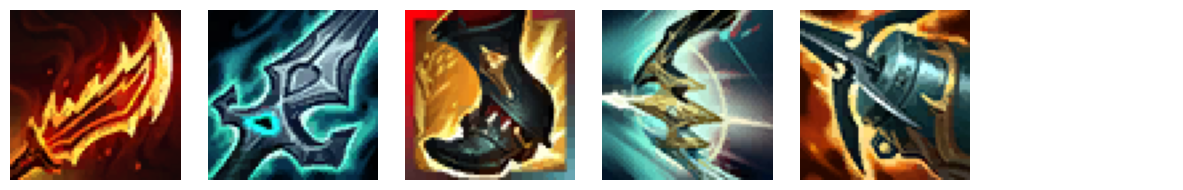

Lane: Bottom
Champion: Kaisa
Allies: Yone, Nautilus, Darius, Elise
Enemies: Lulu, Nasus, Yasuo, Jinx, Malphite
Recommendations: Berserker's Greaves           , Statikk Shiv                  , Nashor's Tooth                , Guinsoo's Rageblade           , Terminus                      , Kraken Slayer                 
Original IDX: 207636
Original build : Berserker's Greaves           , Statikk Shiv                  , Guinsoo's Rageblade           , Terminus                      ,                               ,                               
Recommended build


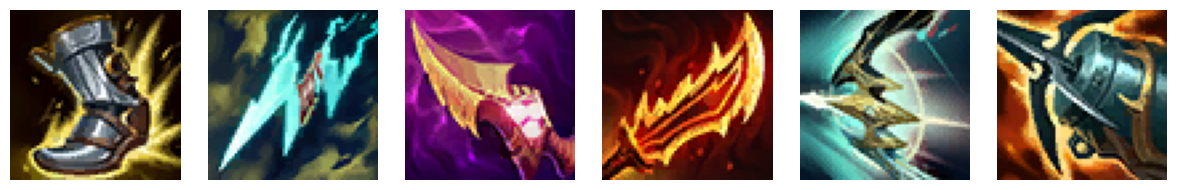

Original build


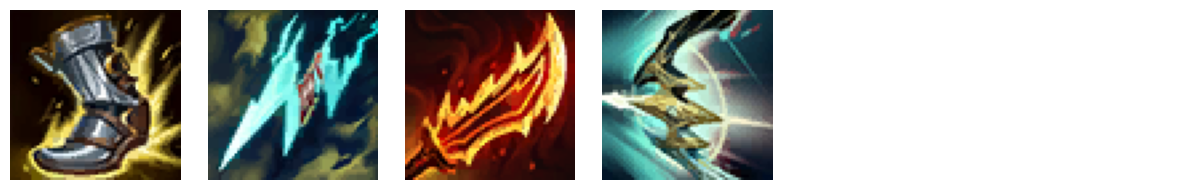

Lane: Bottom
Champion: Kaisa
Allies: Garen, Nautilus, Talon, AurelionSol
Enemies: Urgot, Zeri, Hwei, Ivern, Yuumi
Recommendations: Berserker's Greaves           , Statikk Shiv                  , Nashor's Tooth                , Guinsoo's Rageblade           , Terminus                      , Kraken Slayer                 
Original IDX: 41896
Original build : Berserker's Greaves           , Statikk Shiv                  , Nashor's Tooth                , Guinsoo's Rageblade           , Zhonya's Hourglass            ,                               
Recommended build


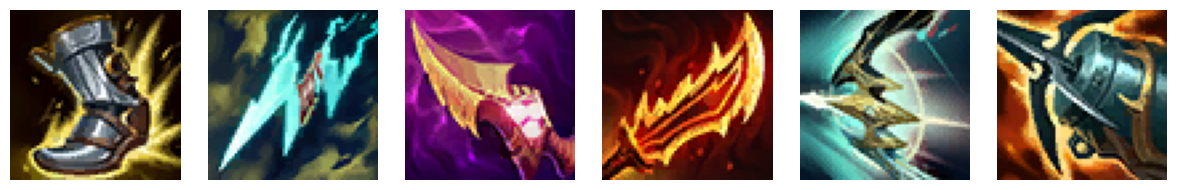

Original build


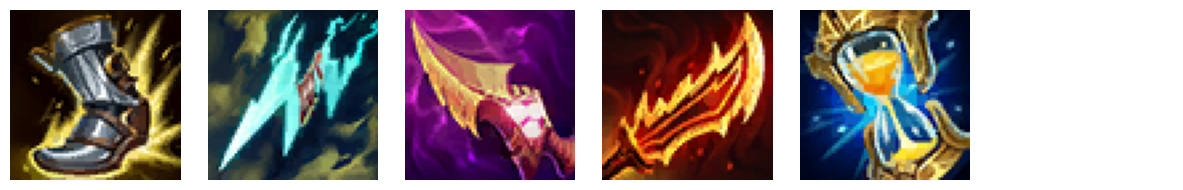

Lane: Bottom
Champion: Kaisa
Allies: Akali, Karma, Hecarim, Cassiopeia
Enemies: Vi, Volibear, TahmKench, Draven, Hwei
Recommendations: Berserker's Greaves           , Yun Tal Wildarrows            , Statikk Shiv                  , Nashor's Tooth                , Guinsoo's Rageblade           , Kraken Slayer                 
Original IDX: 152456
Original build : Sorcerer's Shoes              , Statikk Shiv                  , Void Staff                    , Zhonya's Hourglass            , Essence Reaver                , Shadowflame                   
Recommended build


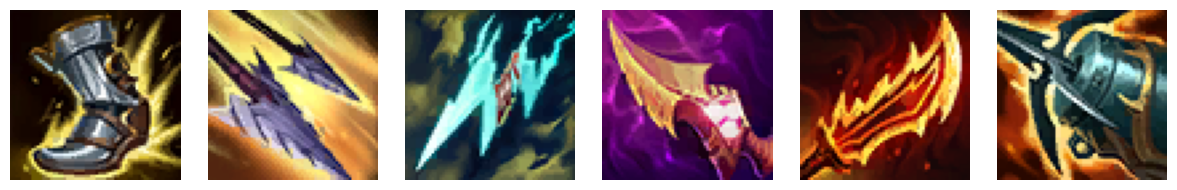

Original build


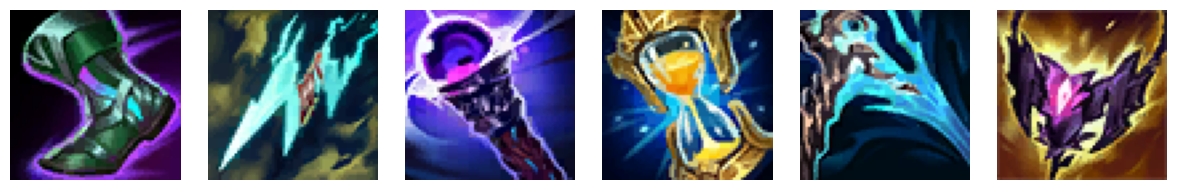

Lane: Bottom
Champion: Kaisa
Allies: Irelia, Viego, Leblanc, Rakan
Enemies: Karma, MasterYi, LeeSin, Ezreal, Jayce
Recommendations: Berserker's Greaves           , Yun Tal Wildarrows            , Statikk Shiv                  , Nashor's Tooth                , Guinsoo's Rageblade           , Kraken Slayer                 
Original IDX: 69197
Original build : Berserker's Greaves           , Yun Tal Wildarrows            , Phantom Dancer                , The Collector                 ,                               ,                               
Recommended build


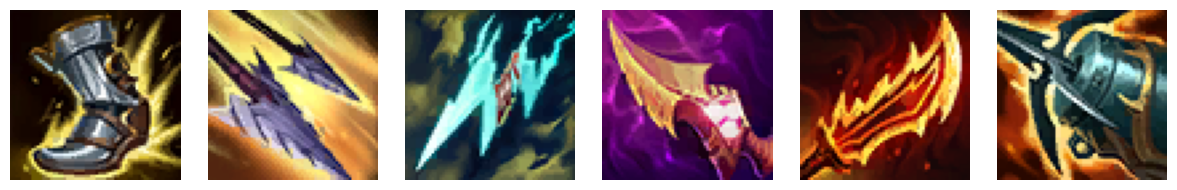

Original build


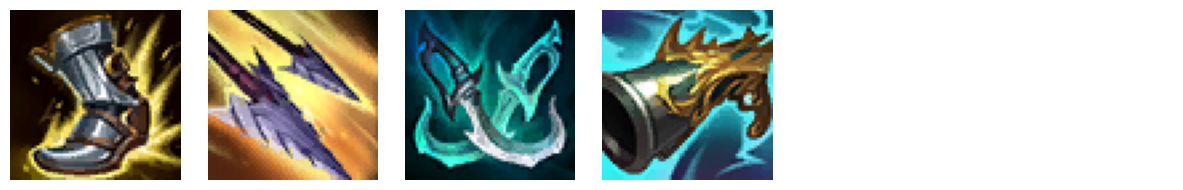

In [ ]:
for index, row in list(df_selected.iterrows())[:10]:
    idx = int(row["index"])
    compare_builds(
        X_test,
        all_recommendations,
        y_test,
        pd.Series(
            {
                idx_from_0:
                    X_test.index[idx_from_0]
                for idx_from_0 in range(len(X_custom))
            }
        ),
        idx
    )

In [ ]:
# Save
torch.save(model.state_dict(), "model_weights.pth")

# Load (later)
model = SimpleMLP()
model.load_state_dict(torch.load("model_weights.pth"))
model.eval()  # Set to eval mode if you're evaluating/inference

TypeError: SimpleMLP.__init__() missing 2 required positional arguments: 'input_dim' and 'output_dim'